# Introduction

The dataset focuses on human resources records. According to the Kaggle description, the following question is asked:

"__Why are our best and most experienced employees leaving prematurely?__" 

We will follow up with the following question:

__Can we predict whether someone will leave?__

## Reading the Data

We will first read the data from the csv file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import IPython

d = pd.read_csv("HR_comma_sep.csv")

print("Number of records " + str(len(d)))
d.head()

Number of records 14999


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


Now, according to the Kaggle dataset, they define the following description for the columns:

* satisfaction_level \- Level of satisfaction (0-1)
* last_evaluation \- Evaluation of employee performance (0-1)
* number_project \- Number of projects completed while at work
* average_montly_hours \- Average monthly hours at workplace
* time_spend_company \- Number of years spent in the company
* Work_accident \- Whether the employee had a workplace accident
* left \- Whether the employee left the workplace or not (1 or 0) Factor
* promotion_last_5years \- Whether the employee was promoted in the last five years
* sales - Department in which they work for
* salary - Relative level of salary (high)

So, the dataset assumes that we are only analysis the records of one company.

## Taking a glimpse

We’ll run some commands on our dataset to get a feeling of our data. This will allow us to determine how we should approach this problem.

First, we’ll check the satisfaction levels:

In [2]:
print("Lowest satisfaction " + str(d['satisfaction_level'].min()))
print("Highest satisfaction " + str(d['satisfaction_level'].max()))

Lowest satisfaction 0.09
Highest satisfaction 1.0


The lowest value is 9% satisfaction, which is someone who’s most likely to have left the company. The highest is 100%, a person who’s unlikely to have left.

Let’s plot the data, where satisfaction_level is the independent variable and left is the dependent variable.

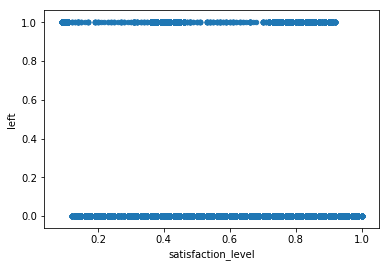

In [3]:
d.plot(kind='scatter',x='satisfaction_level',y='left')

As shown, determining whether they’ll leave due to dissatisfaction is mostly random. Thus, we cannot create a model to determine whether someone is going to leave based on their satisfaction alone. Despite this, we do know that those who are on opposite extremes can be predicted accurately.

We’ll have to experiment with some of the other columns to determine a pattern.

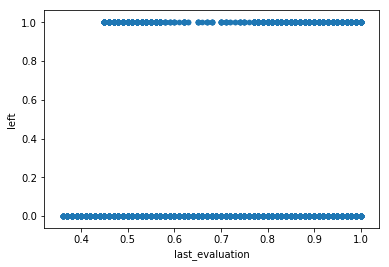

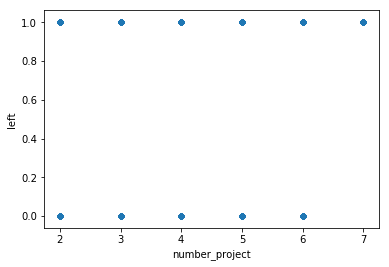

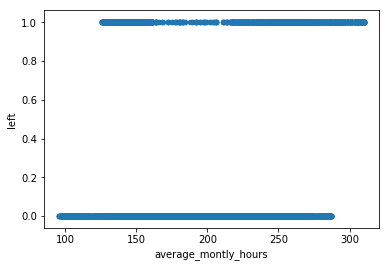

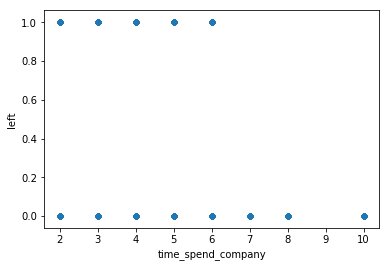

In [4]:
for column in list(d.iteritems())[1:5]:
    d.plot(kind='scatter',x=column[0],y='left')
    plt.show()

Just like the case with satisfaction, attempting to predict whether someone will leave is no better than randomly picking points. We’ll need a better approach to determine how to predict a person leaving the company.

However, we do know a few things that can help us determine whether someone will leave:
* People who worked at the company for more than 6 years never left.
* Assuming a 40 hour work week, people who worked between 100-125 hours would not leave. Conversly, those who worked over 70 hours a week would leave.
* Someone who picked up more than 6 projects would leave.
* It’s interesting to note that those with a lower evaluation would stay. However, they’re also people who would most likely to leave.

Yet, even with these observations, none of this will help if we don’t know which roles people are playing in the company and the circumstances of their employment.

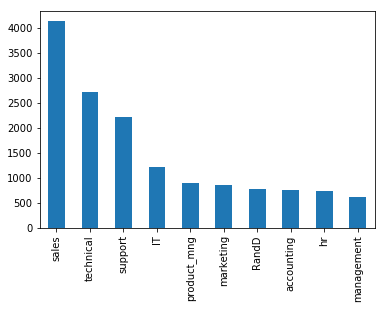

In [5]:
fieldData = d[['sales', 'left']]
fields = fieldData['sales'].value_counts()
fields.plot(kind = 'bar')

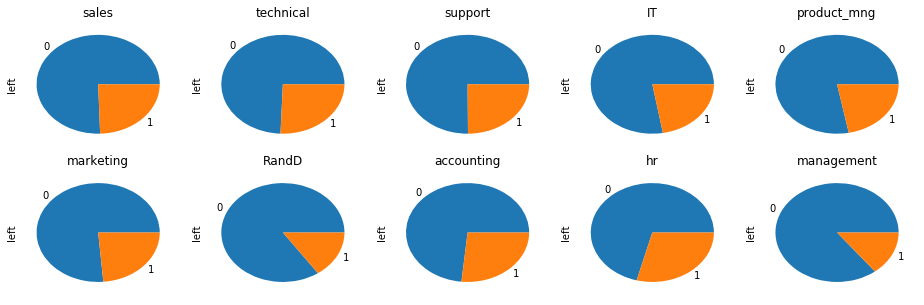

In [6]:
fig, axes = plt.subplots(2, 5, figsize=(16, 5))

# What's the proportion of people that quit in their field?
for i in range(len(fields.keys())):
    field = fields.keys()[i]
    fieldType = fieldData[fieldData['sales'] == field]
    fieldType['left'].value_counts().plot(kind = 'pie',
                                          ax = axes[i // 5, i % 5],
                                          title = field)

Based on charts, most people are associated with sales. We also note that the highest turnover rate is in human resources. In general though, most people have not left the company.

Let’s see if we can establish some rules on a per field-basis. If a certain percentage of cases is exceeded (17% in this case), then we build a rule.

But first, we’ll need to categorize the hour ranges to the following: 

* 160 hours or less (40 hour weeks) 
* 160 hours to 240 hours (40-60 hour weeks) 
* 240 hours to 320 hours (60-80 hour weeks) 
* greater than 320 hours (+80 hour weeks)

We also need to categorize the evaluations and satisfaction using the interquartile range: 

* <=25% - low 
* 25-75% - normal 
* \>75% - high

In [7]:
d['hours_amount_rank'] = 0
d.loc[d['average_montly_hours'] <= 160, 'hours_amount_rank'] = 'low'
d.loc[(d['average_montly_hours'] > 160) & (d['average_montly_hours'] <= 240),
        'hours_amount_rank'] = 'medium'
d.loc[(d['average_montly_hours'] > 240) & (d['average_montly_hours'] <= 320),
        'hours_amount_rank'] = 'high'
d.loc[d['average_montly_hours'] > 320, 'hours_amount_rank'] = 'too high'

d['last_evaluation_rank'] = 0
evalDesc = d['last_evaluation'].describe()
d.loc[d['last_evaluation'] <= evalDesc['25%'], 'last_evaluation_rank'] = 'low'
d.loc[(d['last_evaluation'] > evalDesc['25%']) &
      (d['last_evaluation'] <= evalDesc['75%']), 'last_evaluation_rank'] = 'medium'
d.loc[(d['last_evaluation'] > evalDesc['75%']) &
      (d['last_evaluation'] <= 320), 'last_evaluation_rank'] = 'high'

d['satisfaction_level_rank'] = 0
evalDesc = d['satisfaction_level'].describe()
d.loc[d['satisfaction_level'] <= evalDesc['25%'], 'satisfaction_level_rank'] = 'low'
d.loc[(d['satisfaction_level'] > evalDesc['25%']) &
      (d['satisfaction_level'] <= evalDesc['75%']), 'satisfaction_level_rank'] = 'medium'
d.loc[(d['satisfaction_level'] > evalDesc['75%']) &
      (d['satisfaction_level'] <= 320), 'satisfaction_level_rank'] = 'high'

d.head(5)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary,hours_amount_rank,last_evaluation_rank,satisfaction_level_rank
0,0.38,0.53,2,157,3,0,1,0,sales,low,low,low,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium,high,medium,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium,high,high,low
3,0.72,0.87,5,223,5,0,1,0,sales,low,medium,medium,medium
4,0.37,0.52,2,159,3,0,1,0,sales,low,low,low,low


In [8]:
# The point is devise rules until either the dataset # is empty or we went through all columns
def genRules(data, conf):
    rules = []
    tempRules = []
    currentData = [data]
    columnNames = list(data)[1:]
    i=0
    # While the dataset is not empty
    while len(currentData) != 0 and i != len(columnNames):
        value = len(currentData)
        # Go through all the available datasets 
        for k in range(value):
            theData = currentData[k]
            theNumbers = theData[columnNames[i]].value_counts() / len(theData) > conf 
            hasTrues = 0
            # Look for any columns that meet the threshold
            for j in range(len(theNumbers)):
                myKey = theNumbers.keys()[j]
                myVal = theNumbers[myKey]
                if myVal == True:
                    hasTrues += 1
                    currentData.append(
                            theData[theData[columnNames[i]] == myKey]
                    )
            # Generate the rules
            if hasTrues == 0 or i+1 == len(columnNames):
                rules.append({
                    columnNames[inx]:theData[columnNames[inx]].unique()[0]
                        for inx in range(i)
                })
        currentData = currentData[value:]
        i += 1
    return rules
    
leftData = d[d['left'] == 1]
leftData = leftData[['sales', 'salary', 'number_project',
                     'time_spend_company', 'Work_accident',
                     'promotion_last_5years', 'hours_amount_rank',
                     'last_evaluation_rank', 'satisfaction_level_rank'] ]
for field in fields.keys():
    fieldType = leftData[leftData['sales'] == field]
    theRules = pd.DataFrame(genRules(fieldType, 0.17))
    print("Rules in {}\n".format(field))
    IPython.display.display(theRules[:5])

Rules in sales



,Work_accident,hours_amount_rank,last_evaluation_rank,number_project,promotion_last_5years,salary,time_spend_company
0,0,low,low,2,0,low,3
1,0,high,high,5,0,low,5
2,0,high,medium,5,0,low,5
3,0,medium,high,5,0,low,5
4,0,medium,medium,5,0,low,5


Rules in technical



,Work_accident,hours_amount_rank,last_evaluation_rank,number_project,promotion_last_5years,salary,time_spend_company
0,0,low,low,2,0,low,3
1,0,high,high,6,0,low,4
2,0,high,medium,6,0,low,4
3,0,low,low,2,0,medium,3
4,0,high,high,5,0,medium,5


Rules in support



,Work_accident,hours_amount_rank,last_evaluation_rank,number_project,promotion_last_5years,salary,time_spend_company
0,0,low,low,2,0,low,3
1,0,high,medium,6,0,low,4
2,0,high,high,6,0,low,4
3,0,low,low,2,0,medium,3
4,0,high,high,5,0,medium,5


Rules in IT



,Work_accident,hours_amount_rank,last_evaluation_rank,number_project,promotion_last_5years,salary,time_spend_company
0,0,low,low,2,0,low,3
1,0,high,high,5,0,low,5
2,0,high,medium,5,0,low,5
3,0,medium,medium,5,0,low,5
4,0,medium,high,5,0,low,5


Rules in product_mng



,Work_accident,hours_amount_rank,last_evaluation_rank,number_project,promotion_last_5years,salary,time_spend_company
0,0,low,low,2,0,low,3
1,0,medium,high,5,0,low,5
2,0,medium,medium,5,0,low,5
3,0,high,high,5,0,low,5
4,0,high,medium,5,0,low,5


Rules in marketing



,Work_accident,hours_amount_rank,last_evaluation_rank,number_project,promotion_last_5years,salary,time_spend_company
0,0,low,low,2,0,low,3
1,0,low,low,2,0,medium,3
2,0,medium,high,5,0,medium,5
3,0,medium,medium,5,0,medium,5
4,0,high,medium,5,0,medium,5


Rules in RandD



,Work_accident,hours_amount_rank,last_evaluation_rank,number_project,promotion_last_5years,salary,time_spend_company
0,0,low,low,2,0,medium,3
1,0,medium,high,5,0,medium,5
2,0,high,medium,5,0,medium,5
3,0,high,high,5,0,medium,5
4,0,high,high,5,0,medium,4


Rules in accounting



,Work_accident,hours_amount_rank,last_evaluation_rank,number_project,promotion_last_5years,salary,time_spend_company
0,0,low,low,2,0,medium,3
1,0,high,medium,6,0,medium,4
2,0,high,high,6,0,medium,4
3,0,low,low,2,0,low,3
4,0,high,medium,6,0,low,4


Rules in hr



,Work_accident,hours_amount_rank,last_evaluation_rank,number_project,promotion_last_5years,salary,time_spend_company
0,0,low,low,2,0,medium,3
1,0,high,medium,6,0,medium,4
2,0,high,high,6,0,medium,4
3,0,low,low,2,0,low,3
4,0,medium,high,4,0,low,5


Rules in management



,Work_accident,hours_amount_rank,last_evaluation_rank,number_project,promotion_last_5years,salary,time_spend_company
0,0,low,low,2,0,low,3
1,0,high,medium,6,0,low,4
2,0,high,high,6,0,low,4
3,0,high,medium,4,0,low,5
4,0,low,medium,4,1,low,3


Based on the rules found, we can describe the following:

* Most of the people that leave are being worked at almost 80 hours a week.
* Many of these people are also paid low salaries. Some of them are also earning a medium salary.
* People who work 2 projects have poor evaluations and often work very little.
* The people who worked more than two projects have better evaluations, better paid, but are also overworked. The pay, however, varies from field-to-field.
* Most people in IT, product management, management, human resources have low salaries and are often overworked. It’s possible that they left due to unfavorable working conditions. 
* People in R&D are better paid. They might leave just for better opportunities.

## Predicting the Data

Now, we’ll use a decision tree to determine how well we can predict an employee leaving the company. Unfortunately, scikit-learn doesn’t allow for strings to be used for training, so we’ll need to convert the strings to numbers.

In [9]:
from sklearn import tree

d.loc[d['average_montly_hours'] <= 160, 'hours_amount_rank'] = 0
d.loc[(d['average_montly_hours'] > 160) & (d['average_montly_hours'] <= 240),
        'hours_amount_rank'] = 1
d.loc[(d['average_montly_hours'] > 240) & (d['average_montly_hours'] <= 320),
        'hours_amount_rank'] = 2
d.loc[d['average_montly_hours'] > 320, 'hours_amount_rank'] = 3
d['hours_amount_rank'] = d['hours_amount_rank'].astype(int)

d['last_evaluation_rank'] = 0

evalDesc = d['last_evaluation'].describe()
d.loc[d['last_evaluation'] <= evalDesc['25%'], 'last_evaluation_rank'] = 0
d.loc[(d['last_evaluation'] > evalDesc['25%']) &
      (d['last_evaluation'] <= evalDesc['75%']), 'last_evaluation_rank'] = 1
d.loc[(d['last_evaluation'] > evalDesc['75%']) &
      (d['last_evaluation'] <= 320), 'last_evaluation_rank'] = 2

d['satisfaction_level_rank'] = 0
evalDesc = d['satisfaction_level'].describe()
d.loc[d['satisfaction_level'] <= evalDesc['25%'], 'satisfaction_level_rank'] = 0
d.loc[(d['satisfaction_level'] > evalDesc['25%']) &
      (d['satisfaction_level'] <= evalDesc['75%']), 'satisfaction_level_rank'] = 1
d.loc[(d['satisfaction_level'] > evalDesc['75%']) &
      (d['satisfaction_level'] <= 320), 'satisfaction_level_rank'] = 2

#salary
d.loc[d['salary'] == 'low', 'salary'] = 0
d.loc[d['salary'] == 'medium', 'salary'] = 1
d.loc[d['salary'] == 'high', 'salary'] = 2
d['salary'] = d['salary'].astype(int)

i=0
for field in d['sales'].value_counts().keys():
    d.loc[d['sales'] == field, 'sales'] = i
    i += 1
d['sales'] = d['sales'].astype(int)

trainD = d[:int(len(d)*0.6)]
trainY= trainD['left']
trainX = trainD[['sales', 'salary', 'number_project',
                 'time_spend_company', 'Work_accident',
                 'promotion_last_5years', 'hours_amount_rank',
                 'last_evaluation_rank', 'satisfaction_level_rank'] ]
testD = d[int(len(d)*0.6):]
testY= testD['left']
testX = testD[['sales', 'salary', 'number_project',
               'time_spend_company', 'Work_accident',
               'promotion_last_5years', 'hours_amount_rank',
               'last_evaluation_rank', 'satisfaction_level_rank'] ]

# Train on the data
clf = tree.DecisionTreeClassifier()
clf.fit(trainX,trainY)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [10]:
# Now return the accuracy of the decision tree 
(clf.predict(testX) == testY).sum()/len(testX)

0.94733333333333336

So, we can accurately determine whether someone will leave the company.

## Limitations of Data

From this exercise, we can definitely use the dataset to determine whether an employee will leave the company.

However, even with this knowledge, there are things that the data cannot explain:

* How old are the employees? If the employees are young, it is understandable that they wouldn’t be as satisfied since they are trying to find a better opportunity.
* Could the reason of turnover be company culture related?
* Why do these employees have low satisfation? Why did these people leave? While we can imply certain reasons (too many hours and too many projects, too few hours and too few projects, low pay, etc.), the data does not provide enough information to suggest solutions.
* How effective is management? How many people belong to lower, middle, and upper management? Is there miscommunication between management and employees? 

Despite these limits, there are few questions we can ask:

* Why does human resource field have the highest turnover rates? Is management doing a poor job?
* In the case of IT, does the data suggest an unstable infrastructure? There are many employees who take on many projects with little pay. It’s possible that these employees are either not appreciated or are not very good.
* Why do salesman leave the company? Are they looking for better opportunities?
* We notice a lot of R&D employees leaving with medium salaries. What motivated them to leave?